# Approximate counting Bloom filter

A Bloom filter is a widely-used data structure that is efficient in answering membership queries, which means asking if an element belong to the data structure. It is guaranteed that Bloom filter always answer any membership query with no false negatives, and the probability of false-positive answers can be analyzed with simple theoretical work. Bloom filters are widely use in web data search, network data analysis and genomic dataset comparison.

Despite all the nice properties of a Bloom filter, it doesn't support deletions (remove items from the data structure after they are inserted), complicate some applications that prefer more flexibility. Therefore, an extented data structure called counting Bloom filter (CBF) is proposed. A counting Bloom filter records counts for each bin in the filter, instead of bits for a typical Bloom filter. The advantage of storing counts is the capability of deletions, and a "thresholding membership query" -- asking if an item belongs to the filter with occurrences over a given threshold.

However, replacing bits with counts in a Bloom filter greatly increases the space usage of the data structure. Also, for many scenarios people need to set the size of each bin in the filter based on some high-frequency elements, resulting in wasted bits for many other bins. To deal with this issue, we propose a probabilistic approach for updating counts in the counting Bloom filter. We call this method **approximate counting Bloom filter**.

In [1]:
import xxhash

import random
import sys
import math

# from matplotlib import ticker
# from matplotlib.colors import ListedColormap
# from matplotlib.patches import Patch

from matplotlib import rcParams
from matplotlib import style
import matplotlib.pyplot as plt

style.use('fivethirtyeight')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Trebuchet MS']
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.color'] = 'grey'
plt.rcParams['ytick.color'] = 'grey'

from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'


## Implement hashing and counting Bloom filter objects

`xxhash` library is used for hashing.

In [3]:
# control random seed for reproducibility
random.seed(0)

class HashXX32:
    def __init__(self, seed):
        self.h = xxhash.xxh32(seed=seed)

    def hash(self, o):
        self.h.reset()
        self.h.update(o)
        return self.h.intdigest() % sys.maxsize

class CountingBloomFilter:
    def __init__(
        self,
        num_hash,
        size,
        seed = [],
        verbose = 0,
        max_size = sys.maxsize
    ):
        # num_hash (Int): 
        #     number of hash functions, usually denote as k
        # size (Int): 
        #     size of the filter
        # seed (List) [[]]: 
        #     list of length num_hash; can be None and the seed will be randomly generated
        # verbose (Int) [0]:
        #     increment to raise verbose level
        # max_size (Int) [sys.maxsize]:
        #     the max value of a count
        
        # Randomly decide seeds if not set
        if not seed:
            for i in range(num_hash):
                seed.append(random.randint(0, sys.maxsize - 1))
        self.list_hasher = [HashXX32(s) for s in seed]
        self.num_hash = num_hash
        self.size = size
        self.table = [0] * size
        self.verbose = verbose
        self.max_size = max_size

    def insert(self, obj):
        # Insert the object into the data structure.
        # For each insertion, increment the count by 1
        
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            
            if self.table[list_target_idx] < self.max_size:
                self.table[list_target_idx] += 1
            # Do not update if the bin has reached max_size (print warning if verbose > 0)
            elif self.verbose > 0:
                print (f'fail to increment bin {list_target_idx} when inserting item {obj} because the bin has reached max_size')

            # Print each step if verbose > 1
            if self.verbose > 1:
                print (f'insert {obj} to {list_target_idx}')
                
    def delete(self, obj):
        # Delete the object from the data structure.
        # For each deletion, decrement the count by 1 if its value > 0
        
        # First check if obj is in the filter
        if obj not in self:
            print (f'cannot perform delete(): item {obj} is not in the filter')
            return
        
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            
            if self.table[list_target_idx] > 0:
                self.table[list_target_idx] -= 1
            # Don't decrement if the count is already 0
            elif self.verbose > 0:
                print (f'fail to decrement bin {list_target_idx} when deleting item {obj} because the bin count is already 0')

            # Print each step if verbose > 1
            if self.verbose > 1:
                print (f'delete {obj} from {list_target_idx}')
                
    def __contains__(self, obj):
        # Return True if the object has been added; False if not
        # Don't consider counts here
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            if self.verbose > 0:
                print (f'item {obj} hashed to bin {list_target_idx}')
            if self.table[list_target_idx] == 0:
                return False
        return True
    
    def thresholding_contain(self, obj, threshold):
        # Return True if the min count associated with obj >= threshold; False if not
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            if self.verbose > 0:
                print (f'item {obj} hashed to bin {list_target_idx}, the count of which is {self.table[list_target_idx]}')
            if self.table[list_target_idx] < threshold:
                return False
        return True

    def print_filter(self):
        # Print CBF
        print (self.table)
    
    def estimate_size(self):
        # Return estimated size of the CBF
        return (self.size * math.ceil(math.log2(self.max_size)))
        

## Testing using a small example

We use a small test case to test our counting Bloom filter.
For this example, we print messages showing filter saturation during insertion and queries.

We'd like to know:
1. the size of the data structure (this is the evaluated number, not actual memory usage, because we're just prototyping)

In [4]:
# test case: "countingbloomfilter", 3 hash functions, 30 bins
list_obj = list("countingbloomfilter")
test_cbf = CountingBloomFilter(num_hash = 3, size = 30, verbose = 1, max_size = 5)
size_test_cbf = test_cbf.estimate_size()
print (f'TestCBF is estimated to use {size_test_cbf} bits ({test_cbf.size}x{math.ceil(math.log2(test_cbf.max_size))})')

TestCBF is estimated to use 90 bits (30x3)


2. what the filter is after insertion is completed

As the messages demonstrate, the actual count of $\text{bin}_{24}$ should be 9, but it is saturated at 5 becuase of the `max_size` we set.

In [5]:
for obj in list_obj:
    test_cbf.insert(obj)

print ('TestCBF after insertion:')
test_cbf.print_filter()

fail to increment bin 24 when inserting item f because the bin has reached max_size
fail to increment bin 24 when inserting item i because the bin has reached max_size
fail to increment bin 24 when inserting item i because the bin has reached max_size
fail to increment bin 24 when inserting item t because the bin has reached max_size
TestCBF after insertion:
[0, 0, 0, 5, 0, 2, 2, 0, 3, 0, 0, 2, 2, 2, 1, 4, 1, 2, 0, 3, 3, 1, 2, 4, 5, 1, 4, 2, 2, 0]


3. if it works well for membership queries

We'll see examples of a true-positive (`'i'`), a false-positive (`'x'`) and a true-negative (`'y'`) membership query.

In [6]:
print ('Testing character "i", which is an input element')
print ('i' in test_cbf)
print ()

print ('Testing character "x", which is not an input element')
print ('x' in test_cbf)
print ('*TestCBF returns True for "x", which is due to collision\n')

print ('Testing character "y", which is not an input element')
print ('y' in test_cbf)

Testing character "i", which is an input element
item i hashed to bin 24
item i hashed to bin 13
item i hashed to bin 24
True

Testing character "x", which is not an input element
item x hashed to bin 24
item x hashed to bin 21
item x hashed to bin 16
True
*TestCBF returns True for "x", which is due to collision

Testing character "y", which is not an input element
item y hashed to bin 2
False


In [7]:
print (f'Testing character "u", which occurs {list_obj.count("u")} in the input stream')
print (test_cbf.thresholding_contain('u', 2))
print ()

print (f'Testing character "i", which occurs {list_obj.count("i")} times in the input stream')
print (test_cbf.thresholding_contain('i', 2))
print ()

Testing character "u", which occurs 1 in the input stream
item u hashed to bin 24, the count of which is 5
item u hashed to bin 21, the count of which is 1
False

Testing character "i", which occurs 2 times in the input stream
item i hashed to bin 24, the count of which is 5
item i hashed to bin 13, the count of which is 2
item i hashed to bin 24, the count of which is 5
True



4. deletion

## Experiment using a set of genomic kmers

We extract 6-mers from a 10kb DNA sequence human chromosome 21 (10,000,000,-10,100,000) to perform experiments for our data structures.

In [21]:
fn = 'hg19-chr21-10000000_10100000.fa'

seq = ''
with open(fn, 'r') as f:
    for line in f:
        if line[0] != '>':
            seq += line.rstrip()

# Remove all Ns (there is a big chunk of Ns in the selected region)
seq = seq.replace('N', '')
# seq = seq[:10000]

size_kmer = 6
list_kmer = []
for i in range(len(seq) - size_kmer + 1):
    list_kmer.append(seq[i : i + size_kmer])

print (f'Number of kmers: {len(list_kmer)}')
print (f'Number of distinct kmers: {len(set(list_kmer))}')

# Get counts for each distinct kmer
list_count = []
for s in set(list_kmer):
    list_count.append(list_kmer.count(s))

Number of kmers: 49996
Number of distinct kmers: 3655


Plot the distribution kmer multiplicity. 
Most kmers have few occurrences.

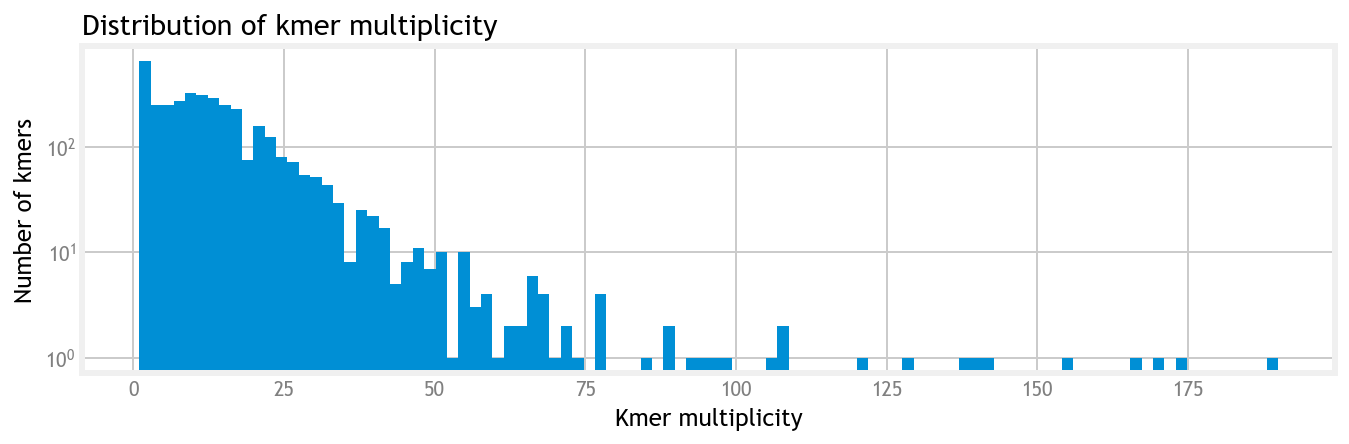

In [20]:
fig, ax = plt.subplots(figsize=(10,3))

ax.set_title('Distribution of kmer multiplicity', loc = 'left')
ax.set_xlabel('Kmer multiplicity')
ax.set_ylabel('Number of kmers')

n, bins, patches = plt.hist(list_count, log=True, bins=100)
plt.show()

The size of input stream $m$ is 49996, and let's set the size of the filter $n$ to be 8192.

## Implement approximate counting

`ApproximateCountingBloomFilter` inherits `CountingBloomFilter`.

Member functions `insert()` is replaced.

In [10]:
class ApproximateCountingBloomFilter(CountingBloomFilter):
    def insert(self, obj):
        # Perform approximate counting.
        # For each insertion, add 1 with probability 2^{-c}, where c is the current bin value
        
        for i in range(self.num_hash):
            list_target_idx = self.list_hasher[i].hash(obj) % self.size
            
            # Bernoulli trial with p = 2^{-c}
            rand_num = random.random()
            if self.table[list_target_idx] < self.max_size:
                if rand_num < 2 ** (- self.table[list_target_idx]):
                    self.table[list_target_idx] += 1
            # Do not update if the bin has reached max_size (print warning if verbose > 0)
            elif self.verbose > 0:
                print (f'insert(): fail to increment bin {list_target_idx} when inserting {obj} because the bin has reached max_size')

            # Print each step if verbose > 1
            if self.verbose > 1:
                print (f'insert(), insert {obj} to {list_target_idx}')
            

In [11]:
test_cbf2 = ApproximateCountingBloomFilter(num_hash = 3, size = 30, verbose = 1, max_size = 5)
for obj in list_obj:
    test_cbf2.insert(obj)

print ('TestCBF2 after insertion:')
test_cbf2.print_filter()
test_cbf.print_filter()
print ()


TestCBF2 after insertion:
[0, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 2, 3, 1, 2, 1, 1, 0]
[0, 0, 0, 5, 0, 2, 2, 0, 3, 0, 0, 2, 2, 2, 1, 4, 1, 2, 0, 3, 3, 1, 2, 4, 5, 1, 4, 2, 2, 0]



In [12]:
random.seed(0)
print (random.random())
print (random.random())
h1 = xxhash.xxh32(seed=0)
h1.reset()
h1.update("1")
print (h1.intdigest() % sys.maxsize)
h2 = xxhash.xxh32(seed=random.randint(0,sys.maxsize))
h2.reset()
h2.update("1")
print (h2.intdigest() % sys.maxsize)

0.8444218515250481
0.7579544029403025
3068971186
2351501194


parameter selection